# Overview of Timeseries predictions (LSTM) Read this first


Notes. 

I am combining LSTM (RNN) with multivariate for predictions

Based on available runtime hardware and constraints, this layer will choose different implementations (cuDNN-based or pure-TensorFlow) to maximize the performance. If a GPU is available and all the arguments to the layer meet the requirement of the cuDNN kernel (see below for details), the layer will use a fast cuDNN implementation.

The requirements to use the cuDNN implementation are:

activation == tanh

recurrent_activation == sigmoid

recurrent_dropout == 0

unroll is False

use_bias is True

Inputs, if use masking, are strictly right-padded.

Eager execution is enabled in the outermost context.

hyperparameters used: 
- WINDOW = 7
- HORIZON = 1

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

the inputs (X) are reshaped into the 3D format expected by LSTMs, namely

[samples, timesteps, features].

# Part 0. Load in Functions

In [ ]:
!pip install Historic-Crypto
!pip install fastquant

     |████████████████████████████████| 5.9 MB 5.9 MB/s 
     |████████████████████████████████| 1.4 MB 49.5 MB/s 
     |████████████████████████████████| 410 kB 56.0 MB/s 
     |████████████████████████████████| 1.5 MB 43.5 MB/s 
     |████████████████████████████████| 503 kB 56.9 MB/s 
     |████████████████████████████████| 197 kB 55.4 MB/s 
     |████████████████████████████████| 2.5 MB 36.7 MB/s 
     |████████████████████████████████| 6.4 MB 26.5 MB/s 
     |████████████████████████████████| 9.5 MB 18.1 MB/s 
     |████████████████████████████████| 97 kB 7.0 MB/s 
     |████████████████████████████████| 138 kB 46.1 MB/s 
     |████████████████████████████████| 843 kB 46.9 MB/s 
     |████████████████████████████████| 96 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
     |████████████████████████████████| 271 kB 15.2 MB/s 
     |████████████████████████████████| 1.1 MB 45.6 MB/s 
     |████████████████████████████████| 3.6 MB 35.4 MB/s 
     |█████████████

## Part 0.1 Import Packages

In [ ]:
# Importing packages needed
import pandas as pd
import matplotlib.pyplot as plt
import csv #section 299
from datetime import datetime, timedelta
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import keras
from keras.models import Sequential
from keras.layers import LSTM
import os



# see step 1: targetted crypto historic data
from Historic_Crypto import HistoricalData
from Historic_Crypto import Cryptocurrencies
from Historic_Crypto import LiveCryptoData
from fastquant import get_crypto_data
from fastquant import backtest


print(keras.__version__)

2.8.0


## Part 0.2 Plotting function: plot_ts

In [ ]:
def plot_ts (timesteps, 
             values, 
             format = '.', #scatter plot
             start = 0, 
             end = None,
             s = 5,
             label = None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across time)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values across time
  format: style of plot, default "."
  start: where to staart the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to start but for the end)
  label: to show on plot

  """

  #plot the series
  plt.plot(timesteps [start:end], values[start:end],format, label = label)
  plt.xlabel ("Time")
  plt.ylabel ("Crypto Price")

  #use with label
  if label:
    plt.legend(fontsize = 14)
  plt.grid (True)


## Part 0.3 Evaluation Metrics

### Mean Abs Squared Error MASE

In [1]:
# MASE implementation on naive forecast
def mean_absolute_scaled_error (y_true, y_pred):
 """
Implement MASE (assuming no seasonality of data)
 """
 mae = tf.reduce_mean(tf.abs(y_true - y_pred))

 #find MAE of naive forecast
 mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) #seasonality is 1 day hence shift of 1
 # find out what the [1:] and [:-1] mean
 
 return mae / mae_naive_no_season 

### Evaluation Metrics

In [2]:
#original is evaluate_preds()
def TS_eval (y_true, y_pred):
  # make sure datatype is float32 for tensorflow
  y_true = tf.cast(y_true, dtype = "float32")
  y_pred = tf.cast(y_pred, dtype = "float32")

  # error metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error (y_true,y_pred)

   #Account for different sized metrics for longer horizon by reducing to single value 
  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse" : mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase":mase.numpy()}

## Part 0.4 Windowing data and features

In [ ]:
# Global variables: conventionally written in caps
HORIZON = 1
WINDOW_SIZE = 7
# Create function to label windowed data
def get_labelled_windows (x, horizon = HORIZON):
  """
  Create labels for windowed dataset

  e.g. If horizon = 1, 
  input: [0,1,2,3,4,5,6,7] - > Output: ([0,1,2,3,4,5,6],[7])

  """

  return x[:,:-horizon], x[:,-horizon:]

In [ ]:
def make_windows (x, window_size = WINDOW_SIZE, horizon = HORIZON):
  """
  turns a 1D array 'x' into a 2D array of squential labelled windows
  """
  #1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)

  #2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis = 0).T #create 2D array of windows 

  print(f"Window indexes:\n {window_indexes},and window shape: {window_indexes.shape}")

  #3. Index on the target array 'x' with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  #4. get the labelled windows
  windows, labels = get_labelled_windows (windowed_array, horizon = horizon)

  #5. final
  return windows , labels

## Part 0.5 Create Train and Test splits

In [ ]:
# create function to make train/test splits
def make_train_test_split(windows, 
                          labels, 
                          test_split = .1):
  #split matching pairs of windows and labels into train and test splits

  split_size = int(len(windows)*(1-test_split)) #this will default to 90% train 10% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  
  #return outputs similar to sklearn
  #same as X_train, X_test, y_train, y_test
  return train_windows, test_windows, train_labels, test_labels

## Part 0.6 Creating a modeling checkpoint

In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Part 0.7 Making predictions function: make_preds

In [ ]:
def make_preds (model, input_data):
  """
  uses model to make predictions input_data.
  """
  predictions = model.predict(input_data)

  return tf.squeeze(predictions) #return 1-D array of predictions

## Part 0.8 Extracting Predictions

In [ ]:
def make_ensemble_preds (ensemble_models, data, type = 'median'):
  
  # create empty list
  ensemble_preds = []

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

  # if type == 'median':
  #  ensemble_med = np.median(ensemble_preds, axis = 0)
  #  return ensemble_med
  # elif type == 'mean':
  #   ensemble_mean = tf.reduce_mean(ensemble_preds, axis = 0)
  # return ensemble_mean

In [ ]:
def get_upper_lower (preds): # 1. take the predictions from a number of randomly intialized models

  # 2. Measure the standard dev of the predictions
  std = tf.math.reduce_std(preds, axis = 0)

  # 3. Muliply SD by 1.96 to find +/- limits
  interval = std*1.96

  # 4. Get the pred interval upp and lower bounds
  preds_mean = tf.reduce_mean(preds, axis = 0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

## Part 0.9 Technical Indicators

### RSI

In [ ]:
def computeRSI(data, time_window):
  diff = data.diff(1).dropna()

  #this preserves dimension of diff values
  up_chg = 0 *diff
  down_chg = 0*diff

  #up change is equal to positive difference, otherwise equal to zero
  up_chg[diff>0] = diff[diff>0]

  #down change is equal to negative difference, otherwise equal to zero
  down_chg[diff < 0] = diff[ diff < 0 ]
  #we set com=time_window-1 so we get decay alpha=1/time_window
  #.ewm is exponential weighted
  up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
  down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

  rs = abs(up_chg_avg/down_chg_avg)
  rsi = 100 -100/(1+rs)

  return rsi


# Part 1: Extracting data

In [ ]:
today = datetime.today().strftime("%Y-%m-%d")
today

'2022-04-05'

In [ ]:
xrp = get_crypto_data("XRP/USDT", start_date = "2009-03-08", end_date = today)
XRP = pd.DataFrame(xrp["close"])

In [ ]:
XRP.rename(columns = {"close":"Price"}, inplace = True)

In [ ]:
XRP

,Price
dt,
2018-05-04,0.88990
2018-05-05,0.90280
2018-05-06,0.86483
2018-05-07,0.82490
2018-05-08,0.80667
...,...
2022-04-01,0.82770
2022-04-02,0.82400
2022-04-03,0.84320


# Part 1.1 Naive Forecast

In [ ]:
split_size = int(0.8*len(XRP))
split_size
y_test = XRP.Price[split_size:].to_numpy()
y_test

array([0.6383, 0.6731, 0.6111, 0.6162, 0.6484, 0.6444, 0.7063, 0.7063,
       0.6591, 0.6556, 0.6732, 0.696 , 0.6526, 0.6648, 0.6522, 0.6215,
       0.6369, 0.6246, 0.6364, 0.6288, 0.6192, 0.6197, 0.5979, 0.5893,
       0.5821, 0.5866, 0.557 , 0.5284, 0.5719, 0.592 , 0.6091, 0.6085,
       0.6069, 0.6234, 0.6451, 0.7327, 0.7488, 0.7521, 0.746 , 0.7242,
       0.738 , 0.7136, 0.731 , 0.7327, 0.7474, 0.8162, 0.7788, 0.817 ,
       0.8511, 1.0105, 0.966 , 1.0901, 1.2791, 1.2839, 1.1855, 1.0978,
       1.1431, 1.2347, 1.2629, 1.2158, 1.226 , 1.2457, 1.1353, 1.1735,
       1.0712, 1.1918, 1.1459, 1.1408, 1.1002, 1.1856, 1.2362, 1.2533,
       1.2907, 1.2548, 1.3076, 1.3894, 1.1292, 1.0998, 1.0868, 1.0552,
       1.0787, 1.1181, 1.0643, 1.0963, 1.1207, 1.0902, 1.0661, 1.0751,
       1.0483, 0.9216, 0.8743, 1.0033, 1.0016, 0.944 , 0.94  , 0.9436,
       0.9218, 0.8928, 0.9268, 0.9533, 1.0422, 1.0359, 1.0552, 1.0425,
       1.0839, 1.0765, 1.0678, 1.0636, 1.1604, 1.1352, 1.1364, 1.1018,
      

In [ ]:
XRP_naive = y_test[:-1] # Naïve forecast equals every value excluding the last value
XRP_naive[:10], XRP_naive[-10:] # View frist 10 and last 10

(array([0.6383, 0.6731, 0.6111, 0.6162, 0.6484, 0.6444, 0.7063, 0.7063,
        0.6591, 0.6556]),
 array([0.8327, 0.858 , 0.8641, 0.8577, 0.8613, 0.8148, 0.8277, 0.824 ,
        0.8432, 0.826 ]))

In [ ]:
naive_results = TS_eval(y_true = y_test[1:],
                        y_pred = XRP_naive)
naive_results

{'mae': 0.031233564,
 'mape': 3.4597628,
 'mase': 1.0004009,
 'mse': 0.0020621934,
 'rmse': 0.04541138}

# Part 2: Preparing Multivariate Data

## Part 2.1: MACD

In [ ]:
XRP["EMA26"] = XRP.ewm(26).mean()
XRP["EMA12"] = XRP.Price.ewm(12).mean()
XRP["MACD"] = XRP["EMA12"]-XRP["EMA26"]
XRP["MACD SIGNAL"] = XRP["MACD"].ewm(9).mean()
XRP["MACD Diff"] = XRP["MACD"] - XRP ["MACD SIGNAL"]

## Part 2.2: RSI

In [ ]:
XRP

,Price,EMA26,EMA12,MACD,MACD SIGNAL,MACD Diff
dt,,,,,,
2018-05-04,0.88990,0.889900,0.889900,0.000000,0.000000,0.000000
2018-05-05,0.90280,0.896472,0.896608,0.000136,0.000072,0.000065
2018-05-06,0.86483,0.885524,0.885157,-0.000367,-0.000090,-0.000277
2018-05-07,0.82490,0.869500,0.868239,-0.001261,-0.000430,-0.000830
2018-05-08,0.80667,0.855968,0.853879,-0.002088,-0.000835,-0.001253
...,...,...,...,...,...,...
2022-04-01,0.82770,0.793855,0.814415,0.020560,0.010805,0.009755
2022-04-02,0.82400,0.794972,0.815153,0.020181,0.011743,0.008438
2022-04-03,0.84320,0.796758,0.817310,0.020552,0.012624,0.007929


In [ ]:
XRP['RSI'] = computeRSI(XRP.Price,14)
XRP = XRP.dropna()
XRP

,Price,EMA26,EMA12,MACD,MACD SIGNAL,MACD Diff,RSI
dt,,,,,,,
2018-05-18,0.67766,0.747029,0.735109,-0.011919,-0.007510,-0.004409,28.060423
2018-05-19,0.67339,0.741012,0.728535,-0.012477,-0.008120,-0.004357,27.588142
2018-05-20,0.69940,0.737757,0.725521,-0.012237,-0.008614,-0.003623,34.788107
2018-05-21,0.67612,0.733127,0.720542,-0.012585,-0.009081,-0.003504,31.745600
2018-05-22,0.63782,0.726230,0.712399,-0.013831,-0.009630,-0.004201,27.486476
...,...,...,...,...,...,...,...
2022-04-01,0.82770,0.793855,0.814415,0.020560,0.010805,0.009755,53.329978
2022-04-02,0.82400,0.794972,0.815153,0.020181,0.011743,0.008438,52.510481
2022-04-03,0.84320,0.796758,0.817310,0.020552,0.012624,0.007929,56.266074


## Part 2.3: visualisation

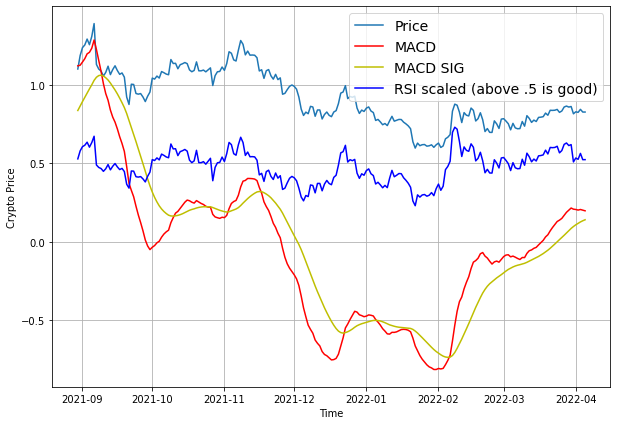

In [ ]:
# Plot the new variables to see what they look like
plt.figure (figsize = (10,7))
offset = 1200
plot_ts(timesteps = XRP.index,
        values = XRP.Price,
        start = offset,
        format = '-',
        label = "Price")
plot_ts(timesteps = XRP.index,
        values = XRP.MACD*10,
        start = offset,
        format = 'r-',
        label = 'MACD')
plot_ts(timesteps = XRP.index,
        values = XRP["MACD SIGNAL"]*10,
        start = offset,
        format = 'y-',
        label = "MACD SIG")
plot_ts(timesteps = XRP.index,
        values = XRP.RSI/100,
        start = offset,
        format = 'b-',
        label = "RSI scaled (above .5 is good)")

# Part 2.1 Scaling the data

In [ ]:
XRP_copy = XRP.copy()
XRP_copy[["Price", "MACD","RSI","MACD SIGNAL","MACD Diff"]]= StandardScaler().fit_transform(XRP_copy
                                                                                        [["Price", "MACD","RSI","MACD SIGNAL","MACD Diff"]]    )

In [ ]:
XRP_std = XRP_copy.drop(["EMA26","EMA12"], axis = 1)

In [ ]:
XRP_std

,Price,MACD,MACD SIGNAL,MACD Diff,RSI
dt,,,,,
2018-05-18,0.586599,-0.249092,-0.179679,-0.214390,-1.717013
2018-05-19,0.573184,-0.259689,-0.192484,-0.211933,-1.756065
2018-05-20,0.654898,-0.255121,-0.202861,-0.177326,-1.160723
2018-05-21,0.581760,-0.261746,-0.212675,-0.171734,-1.412298
2018-05-22,0.461436,-0.285427,-0.224209,-0.204561,-1.764471
...,...,...,...,...,...
2022-04-01,1.057970,0.368242,0.204974,0.453013,0.372445
2022-04-02,1.046346,0.361035,0.224665,0.390970,0.304684
2022-04-03,1.106666,0.368091,0.243167,0.366955,0.615222


# Part 3: Creating the price windows

In [ ]:
for i in range (WINDOW_SIZE):
  XRP_std[f"Price+{i+1}"] = XRP_std["Price"].shift(periods = i + 1)
  XRP_std[f"RSI+{i+1}"] = XRP_std["RSI"].shift(periods = i + 1)
  XRP_std[f"MACD Diff+{i+1}"] = XRP_std["MACD Diff"].shift(periods = i + 1)

XRP_std = XRP_std.dropna()

In [ ]:
XRP_std

,Price,MACD,MACD SIGNAL,MACD Diff,RSI,Price+1,RSI+1,MACD Diff+1,Price+2,RSI+2,...,MACD Diff+4,Price+5,RSI+5,MACD Diff+5,Price+6,RSI+6,MACD Diff+6,Price+7,RSI+7,MACD Diff+7
dt,,,,,,,,,,,,,,,,,,,,,
2018-05-25,0.357039,-0.369193,-0.271656,-0.305769,-1.586221,0.431024,-1.394878,-0.280806,0.317423,-2.099553,...,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933,0.586599,-1.717013,-0.214390
2018-05-26,0.369385,-0.387511,-0.288507,-0.313374,-1.511483,0.357039,-1.586221,-0.305769,0.431024,-1.394878,...,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933
2018-05-27,0.355688,-0.404364,-0.305389,-0.317279,-1.549664,0.369385,-1.511483,-0.313374,0.357039,-1.586221,...,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326
2018-05-28,0.175766,-0.448449,-0.325555,-0.381323,-1.987887,0.355688,-1.549664,-0.317279,0.369385,-1.511483,...,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734
2018-05-29,0.342556,-0.456308,-0.344338,-0.358664,-1.057693,0.175766,-1.987887,-0.381323,0.355688,-1.549664,...,-0.305769,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,1.057970,0.368242,0.204974,0.453013,0.372445,1.017443,0.167095,0.513256,1.163530,1.078236,...,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154,1.046032,0.645248,0.577902
2022-04-02,1.046346,0.361035,0.224665,0.390970,0.304684,1.057970,0.372445,0.453013,1.017443,0.167095,...,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154
2022-04-03,1.106666,0.368091,0.243167,0.366955,0.615222,1.046346,0.304684,0.390970,1.057970,0.372445,...,0.605479,1.152220,1.028333,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387


In [ ]:
XRP_2 = XRP_std.drop(["RSI","MACD Diff","MACD","MACD SIGNAL"], axis =1)
XRP_2

,Price,Price+1,RSI+1,MACD Diff+1,Price+2,RSI+2,MACD Diff+2,Price+3,RSI+3,MACD Diff+3,...,MACD Diff+4,Price+5,RSI+5,MACD Diff+5,Price+6,RSI+6,MACD Diff+6,Price+7,RSI+7,MACD Diff+7
dt,,,,,,,,,,,,,,,,,,,,,
2018-05-25,0.357039,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561,...,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933,0.586599,-1.717013,-0.214390
2018-05-26,0.369385,0.357039,-1.586221,-0.305769,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,...,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933
2018-05-27,0.355688,0.369385,-1.511483,-0.313374,0.357039,-1.586221,-0.305769,0.431024,-1.394878,-0.280806,...,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326
2018-05-28,0.175766,0.355688,-1.549664,-0.317279,0.369385,-1.511483,-0.313374,0.357039,-1.586221,-0.305769,...,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734
2018-05-29,0.342556,0.175766,-1.987887,-0.381323,0.355688,-1.549664,-0.317279,0.369385,-1.511483,-0.313374,...,-0.305769,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,1.057970,1.017443,0.167095,0.513256,1.163530,1.078236,0.605479,1.152220,1.028333,0.610697,...,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154,1.046032,0.645248,0.577902
2022-04-02,1.046346,1.057970,0.372445,0.453013,1.017443,0.167095,0.513256,1.163530,1.078236,0.605479,...,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154
2022-04-03,1.106666,1.046346,0.304684,0.390970,1.057970,0.372445,0.453013,1.017443,0.167095,0.513256,...,0.605479,1.152220,1.028333,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387


In [ ]:
X = XRP_2.drop(["Price"], axis = 1)
y = XRP_2.Price

X,y

(             Price+1     RSI+1  MACD Diff+1   Price+2     RSI+2  MACD Diff+2  \
 dt                                                                             
 2018-05-25  0.431024 -1.394878    -0.280806  0.317423 -2.099553    -0.274739   
 2018-05-26  0.357039 -1.586221    -0.305769  0.431024 -1.394878    -0.280806   
 2018-05-27  0.369385 -1.511483    -0.313374  0.357039 -1.586221    -0.305769   
 2018-05-28  0.355688 -1.549664    -0.317279  0.369385 -1.511483    -0.313374   
 2018-05-29  0.175766 -1.987887    -0.381323  0.355688 -1.549664    -0.317279   
 ...              ...       ...          ...       ...       ...          ...   
 2022-04-01  1.017443  0.167095     0.513256  1.163530  1.078236     0.605479   
 2022-04-02  1.057970  0.372445     0.453013  1.017443  0.167095     0.513256   
 2022-04-03  1.046346  0.304684     0.390970  1.057970  0.372445     0.453013   
 2022-04-04  1.106666  0.615222     0.366955  1.046346  0.304684     0.390970   
 2022-04-05  1.052630  0.285

In [ ]:
X.shape

(1412, 21)

## Part 3.1 Testing only - try breaking by index

In [ ]:
# example
a = np.arange(0,17,2)
b = np.arange (12,39,3)
c = [100,200,300,400,500,600,700,800,900]

In [ ]:
a,b

(array([ 0,  2,  4,  6,  8, 10, 12, 14, 16]),
 array([12, 15, 18, 21, 24, 27, 30, 33, 36]))

In [ ]:
trial = pd.DataFrame([a,b,c], index = ["t1", "t2","t3"]) 

In [ ]:
trial

,0,1,2,3,4,5,6,7,8
t1,0,2,4,6,8,10,12,14,16
t2,12,15,18,21,24,27,30,33,36
t3,100,200,300,400,500,600,700,800,900


In [ ]:
for i in range(len(trial.index)):
  print(i)

0
1
2


In [ ]:
list1 = []
for i in range(len(trial.index)):
  x = np.reshape(trial.iloc[i].values, (3,3))
  list1.append(x)
  

In [ ]:
list1

[array([[ 0,  2,  4],
        [ 6,  8, 10],
        [12, 14, 16]]), array([[12, 15, 18],
        [21, 24, 27],
        [30, 33, 36]]), array([[100, 200, 300],
        [400, 500, 600],
        [700, 800, 900]])]

In [ ]:
list1[0]

array([[ 0,  2,  4],
       [ 6,  8, 10],
       [12, 14, 16]])

In [ ]:
np.array(list1).shape

(3, 3, 3)

## Part 3.2 Preparing 3D format expected by LSTMs [samples, timesteps, features].

In [ ]:
X

,Price+1,RSI+1,MACD Diff+1,Price+2,RSI+2,MACD Diff+2,Price+3,RSI+3,MACD Diff+3,Price+4,...,MACD Diff+4,Price+5,RSI+5,MACD Diff+5,Price+6,RSI+6,MACD Diff+6,Price+7,RSI+7,MACD Diff+7
dt,,,,,,,,,,,,,,,,,,,,,
2018-05-25,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561,0.581760,...,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933,0.586599,-1.717013,-0.214390
2018-05-26,0.357039,-1.586221,-0.305769,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,...,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326,0.573184,-1.756065,-0.211933
2018-05-27,0.369385,-1.511483,-0.313374,0.357039,-1.586221,-0.305769,0.431024,-1.394878,-0.280806,0.317423,...,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734,0.654898,-1.160723,-0.177326
2018-05-28,0.355688,-1.549664,-0.317279,0.369385,-1.511483,-0.313374,0.357039,-1.586221,-0.305769,0.431024,...,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561,0.581760,-1.412298,-0.171734
2018-05-29,0.175766,-1.987887,-0.381323,0.355688,-1.549664,-0.317279,0.369385,-1.511483,-0.313374,0.357039,...,-0.305769,0.431024,-1.394878,-0.280806,0.317423,-2.099553,-0.274739,0.461436,-1.764471,-0.204561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,1.017443,0.167095,0.513256,1.163530,1.078236,0.605479,1.152220,1.028333,0.610697,1.172326,...,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154,1.046032,0.645248,0.577902
2022-04-02,1.057970,0.372445,0.453013,1.017443,0.167095,0.513256,1.163530,1.078236,0.605479,1.152220,...,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387,1.073679,0.764947,0.566154
2022-04-03,1.046346,0.304684,0.390970,1.057970,0.372445,0.453013,1.017443,0.167095,0.513256,1.163530,...,0.605479,1.152220,1.028333,0.610697,1.172326,1.164224,0.613213,1.153162,1.089630,0.591387


In [ ]:
X_lstm = []
for i in range(len(X.index)):
  lstm = np.reshape(X.iloc[i].values, (7,3))
  X_lstm.append(lstm)

In [ ]:
X_lstm_ready = np.array(X_lstm)
X_lstm_ready, X_lstm_ready.shape

(array([[[ 0.43102447, -1.3948785 , -0.28080556],
         [ 0.31742272, -2.09955279, -0.27473908],
         [ 0.46143556, -1.76447098, -0.20456099],
         ...,
         [ 0.65489785, -1.16072255, -0.17732638],
         [ 0.57318375, -1.75606457, -0.21193276],
         [ 0.58659856, -1.71701315, -0.21438973]],
 
        [[ 0.35703882, -1.58622057, -0.30576909],
         [ 0.43102447, -1.3948785 , -0.28080556],
         [ 0.31742272, -2.09955279, -0.27473908],
         ...,
         [ 0.58176044, -1.41229767, -0.17173352],
         [ 0.65489785, -1.16072255, -0.17732638],
         [ 0.57318375, -1.75606457, -0.21193276]],
 
        [[ 0.36938547, -1.51148323, -0.31337395],
         [ 0.35703882, -1.58622057, -0.30576909],
         [ 0.43102447, -1.3948785 , -0.28080556],
         ...,
         [ 0.46143556, -1.76447098, -0.20456099],
         [ 0.58176044, -1.41229767, -0.17173352],
         [ 0.65489785, -1.16072255, -0.17732638]],
 
        ...,
 
        [[ 1.04634639,  0.30468385

In [ ]:
# Part 3.3 Split into train and test sets
split_size = int(len(X)*.8)

train_X=X_lstm_ready[:split_size]
train_y=y[:split_size]

test_X=X_lstm_ready[split_size:]
test_y=y[split_size:]

In [ ]:
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((1129, 7, 3), (1129,), (283, 7, 3), (283,))

# Part 4: Model time (standard)

notes. see https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/ for more details

notes2. See https://machinelearningmastery.com/stacked-long-short-term-memory-networks/ for stacking layers

## Create LSTM Model

In [ ]:
"""
inputs = layers.Input(shape = train_X.shape[1:3]) #need to define the input shape
x = layers.LSTM(128, activation = 'relu', dropout = .2, return_sequences = True)
output = x(inputs) #i dont know how this worked. see notes. 

LSTM_model = tf.keras.Model(inputs = inputs, 
                         outputs = output, 
                         name = "LSTM_model")

#compile model
LSTM_model.compile (loss = "mae",
                    optimizer = tf.keras.optimizers.Adam())"""


"""#from link above
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]))) #7,3
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')"""

#original
"""inputs = layers.Input(shape = train_X.shape[1:3])
layer1 = layers.LSTM(128, activation = 'elu', dropout = .05, return_sequences = False)(inputs)
output = layers.Dense(HORIZON)(layer1) #dont know why this worked

model_lstm = tf.keras.Model(inputs = inputs, 
                         outputs = output, 
                         name = "model_LSTM")
"""

model_lstm = Sequential(name = "model_lstm")
model_lstm.add(LSTM(512, return_sequences=True, #true is useful for stacking multiple layers
                    input_shape=train_X.shape[1:3], 
                    activation = 'tanh', 
                    kernel_initializer = 'lecun_normal',
                    dropout = .2))
model_lstm.add(LSTM(256, return_sequences=True,
                    activation = 'tanh', 
                    kernel_initializer = 'lecun_normal',
                    dropout = .2))
model_lstm.add(LSTM(256, return_sequences=False, 
                    activation = 'tanh', 
                    kernel_initializer = 'lecun_normal',
                    dropout = .2))
model_lstm.add(tf.keras.layers.Dense(HORIZON))



I followed this:

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

In [ ]:
#compile model
model_lstm.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Nadam())

In [ ]:
model_lstm.summary(), train_X.shape[1:3]

Model: "model_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 7, 512)            1056768   
                                                                 
 lstm_10 (LSTM)              (None, 7, 256)            787456    
                                                                 
 lstm_11 (LSTM)              (None, 256)               525312    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,369,793
Trainable params: 2,369,793
Non-trainable params: 0
_________________________________________________________________


(None, (7, 3))

Note. view this. Not sure if the output shape is correct?

## Fit LSTM Model

In [ ]:
%%time
#fit model
model_lstm.fit(train_X,
            train_y, 
            epochs = 300,
            verbose = 0,
            batch_size = 32,
            validation_data = (test_X, test_y),
            callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                                    patience = 50,
                                                                    verbose = 1),
                         create_model_checkpoint(model_name = model_lstm.name),
                         tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=100,
                                                          verbose=0,
                                                          restore_best_weights=True)]
                  )

INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_lstm/assets



Epoch 106: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 156: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 30min 24s, sys: 1min 38s, total: 32min 2s
Wall time: 18min 23s


In [ ]:
# load in best model
model_lstm = tf.keras.models.load_model("model_experiments/model_lstm")

# evaluate
model_lstm.evaluate(test_X, test_y)

9/9 [==============================] - 1s 39ms/step - loss: 0.3026


0.3025597035884857

In [ ]:
# make predictions
model_lstm_pred = make_preds(model_lstm, test_X)

model_lstm_res = TS_eval(y_pred = model_lstm_pred, y_true = test_y)
model_lstm_res

{'mae': 0.3025597,
 'mape': 23.936003,
 'mase': 3.0866334,
 'mse': 0.15853056,
 'rmse': 0.39815897}

## Part 4.1 plot results to check

In [ ]:
test_y

dt
2021-06-27    0.494674
2021-06-28    0.482108
2021-06-29    0.676575
2021-06-30    0.676575
2021-07-01    0.528290
                ...   
2022-04-01    1.057970
2022-04-02    1.046346
2022-04-03    1.106666
2022-04-04    1.052630
2022-04-05    1.052944
Name: Price, Length: 283, dtype: float64

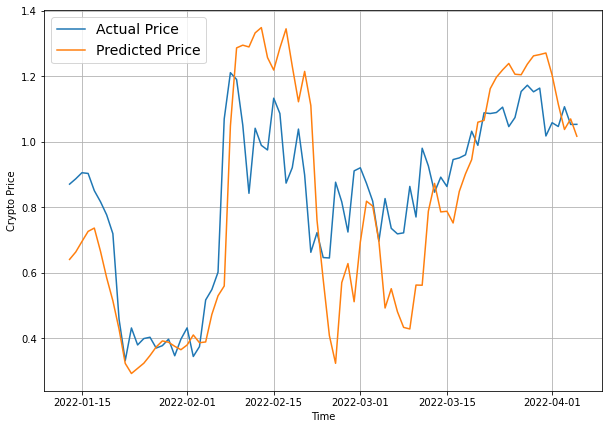

In [ ]:
plt.figure(figsize = (10,7))
offset = 200
plot_ts(timesteps = test_y.index,
        start = offset,
        label = "Actual Price",
        format = '-',
        values = test_y)
plot_ts(timesteps = test_y.index,
        start = offset,
        label = "Predicted Price",
        format = '-',
        values = model_lstm_pred)